# Product Clustering : a geographical analysis
In this notebook we try to give an answer to the following questions:

1. Are similar areas in terms of typical products geographically close?
2. Can we naturally cluster areas geographically when it comes to food consumption in London?
3. How do those clusters differ when we vary the aggregation level?
4. In the context of an advertising campaign, which areas of the city should be associated with which kind of products?

Before answering those questions we will first visualise our dataset to understand if we could even hope to be able to demonstrate such a relationishp between product and geography.

# Interactive visualization
## Data Loading
### Statistical GIS Boundary Files dataset
In the section, we will use ```geopandas``` to load the [Statistical GIS Boundary Files for London](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london). Even if this dataset was made avialable in 2011, we should note that the boundaries haven't really changed compared to 2015 (date of Tesco Dataset) and it should not impact our visualisation.

For each aggregation level ```LSOA```, ```MSOA```, ```WARD```, ```BOROUGH``` we read the correponding file and retreive the following subset of columns: 

* ```area_id ```: the id of the area considered
* ```name    ```: the name of the area considered
* ```geometry```: the geometric shape of the area in the 2D london map (polygon or multipolygon if the area is definied in multiple pieces)

We then store the resulting geopandas dataframe into a dictionary for later usage.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import warnings
#warnings.filterwarnings('ignore')
#data path
data_path = 'data/'
geo_path  = data_path + 'statistical-gis-boundaries-london/ESRI2/'
#read geopandas df and selected subset of columns
gdf_lsoa = gpd.read_file(geo_path + 'LSOA_2011_London_gen_MHW.shp' )[['LSOA11CD','LSOA11NM','geometry']]\
            .rename(columns={'LSOA11CD':'area_id','LSOA11NM':'name'})
gdf_msoa = gpd.read_file(geo_path + 'MSOA_2011_London_gen_MHW.shp' )[['MSOA11CD','MSOA11NM','geometry']]\
            .rename(columns={'MSOA11CD':'area_id','MSOA11NM':'name'})
gdf_ward = gpd.read_file(geo_path + 'London_Ward_CityMerged.shp')[['GSS_CODE','NAME','geometry']]\
            .rename(columns={'GSS_CODE':'area_id','NAME':'name'})
gdf_borough = gpd.read_file(geo_path + 'London_Borough_Excluding_MHW.shp' )[['GSS_CODE','NAME','geometry']]\
            .rename(columns={'GSS_CODE':'area_id','NAME':'name'})
#store them into a dictionary
gdf = {'lsoa':gdf_lsoa,'msoa':gdf_msoa,'osward':gdf_ward,'borough':gdf_borough}
gdf_lsoa.head()

,area_id,name,geometry
0,E01000001,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."


### Tesco data set

We can proceed further by reading the tesco dataset. This dataset contains a subset of the orginal tesco dataset containing some of typical product features:

> ```fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutriments_calories```

Moreover, it stores these features for each combinaison of 

 * ```aggretation level``` : lsoa, msoa, ward, borough 
 * ```period```            : January, February,..., December as well as the yearly aggregation (Year)

In [2]:
tesco = pd.read_csv('data/tesco.csv')
tesco.head()

,area_id,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories,month,agg_level
0,E09000001,8.472985,3.361599,9.278065,5.253333,15.779639,1.619850,165.851751,1.618208,yea,borough
1,E09000002,9.209959,3.596834,10.793244,5.193872,19.784988,1.590335,187.174390,1.545272,yea,borough
2,E09000003,8.594464,3.407353,9.530548,5.129627,17.025950,1.638639,170.655504,1.581507,yea,borough
3,E09000004,9.119180,3.466346,10.941085,5.304496,19.997105,1.657118,187.754791,1.551703,yea,borough
4,E09000005,8.962466,3.559913,10.148610,5.132915,18.726476,1.585978,180.510586,1.555736,yea,borough


The following cell aims at constructing a efficient indexing data structure that allows to easily retrieve the typical product for a given aggregation level and period in order to speed up the refreshing time of the visualization. We used a dictionary for this purpose.

In [3]:
def create_datasource(tesco):
    periods          = list(tesco.month.unique())
    agg_levels       = list(tesco.agg_level.unique())
    feature_names    = [c for c in tesco.columns if c not in ['area_id','month','agg_level']]

    tesco_dict = dict()
    for level in agg_levels:
        inner = dict()
        for mo in periods:
            df_mo_level = tesco.query("agg_level == @level and month == @mo")
            inner[mo]   = gdf[level].merge(df_mo_level, on='area_id', how = 'left').fillna('No data')
        tesco_dict[level] = inner
    return tesco_dict,periods,agg_levels,feature_names

tesco_dict,periods,agg_levels,feature_names = create_datasource(tesco)

### Convert data into JSON format for Bokeh

The bokeh library we are going to use to make the interactive visualization requires the data to be encoded in a JSON format. Given an ```agg_level``` and a ```month``` the following function will performs this encoding.

In [4]:
import json
#Convert data to json
def json_data(agg_level,month,feature=None,data=tesco_dict):
    mo = data[agg_level][month]
    merged_json = json.loads(mo.to_json())
    json_data = json.dumps(merged_json)
    return json_data

## Visualization creation

Since we want to create an interactive visualization we need to store the current state of the application. We choose to simply record in a dict named ```state```:

1. ```agg_level```: the aggregation level 
2. ```feature  ```: the feature of the typical product (or custering) that 
3. ```month    ```: Jan, Feb,..., Dec as well as the yearly aggregation (Year)

### Color Bar helper functions
In this first section we will define several helper functions that will be used for the visualization. We will focus in creating a ```color bar``` for the visualization. It should obsivously depend on the feature analysed (it will define de range of the color bar).

In [5]:
def get_feature(state:dict,tesco_dict=tesco_dict):
    """
    Returns the pd.Series associated to state where the missing values are 
    filtered and the type is converted from string to double
    """
    #get the data from the aggregation
    data = tesco_dict[state['agg_level']][state['month']][state['feature']]
    data = data[data != 'No data']  # filter missing values
    data = data.astype(np.double)   # convert into double
    out  = data if len(data)>0 else None
    return out

def create_color_mapper(state:dict,n_default_colors=8,nan_color='#d9d9d9'):
    """
    This function create the color mapper used in the colorbar for the given state
    """
    feature  = get_feature(state)                    # Select feature
    if state['feature'].startswith('cluster'):
        n_colors = max(feature.nunique(),3) if feature is not None else 1
        palette  = Category10[max(n_colors,3)][:n_colors]
    else:
        n_colors = n_default_colors
        palette  = brewer['YlGnBu'][n_colors]           # Reverse : dark blue is for highest values.
        palette  = palette[::-1]                        # Create a linear color mapper with right range
    low  = 0 if feature is None else feature.min()
    high = 1 if feature is None else feature.max()
    color_mapper = LinearColorMapper(
            palette = palette, nan_color = nan_color,   # nan color
            low = low, high = high)                     # right range
    return color_mapper

def create_color_bar(state:dict,plot,geosource):
    """
    Creates the color bar given the state and geosource and link it to the plot
    """
    color_mapper = create_color_mapper(state)       # use previous function to create the mapper
    color_bar = ColorBar(color_mapper=color_mapper, # set the mapper
        label_standoff=8,width = 500, height = 20,  # specify size 
        border_line_color=None,                     # style : no border lines
        location = (0,0), orientation ='horizontal')# horizontal bar 
    # link color bar and plot 
    plot.patches('xs','ys', source = geosource,     # link geosource
        fill_color = {'field' :state['feature'],    # color related to selected feature
                      'transform':color_mapper},    # use the defined colormapper
        line_color = 'black',                       # style : black borders
        line_width = 0.25, fill_alpha = 1)          # more styling
    plot.add_layout(color_bar, 'below')             # add color bar below plot
    return color_bar

### Handling events : user clicks and changes
The following method will handle the interactivity in our plot. When the user select a new ```month```, ```agg_level``` or ```feature```, we need to update:

1. The title of the plot
2. The color mapper of the plot since the range of value has changed. We choose to only update it when we change the feature. In that way it is still possible to compare the results accross months
3. the hover 

In [6]:
def update_plot(state_field:str, new_val:str,state:dict,plot,geosource,color_bar):
    """
    Handles interactivity in the visualization
    @param state_field : (str) element of the state that needs to be updated
    @param new_val     : (str) new value of state_field element 
    """
    state[state_field] = new_val  # state update
    # update title
    plot.title.text = "{feature} consumption for {agg_level} during the prediod {month}".format(**state)
    if state_field == 'feature':                    # update color mapper
        color_mapper = create_color_mapper(state)   # create new mapper
        color_bar.color_mapper = color_mapper       # set the new mapper in color bar
        plot.patches('xs','ys',                     # update patches
            source = geosource,
            fill_color = {'field' :state['feature'], 'transform' : color_mapper},
            line_color = 'black', line_width = 0.25, fill_alpha = 1)
    new_data = json_data(**state)                   # get the new data and convert to JSON
    geosource.geojson = new_data                    # set new data to trigger recoloring event
    # new hover for the new feature 
    hover = HoverTool(tooltips = [('Area name','@name'),(state['feature'], '@'+state['feature'])])
    # add hover tools to plot
    plot.tools = [hover]

### Creation of the actual figure and components
Here is are the actual components defined. We created a ```bkapp``` (bokeh application) function that given the ```doc``` (bokeh document), creates the components :

1. ```plot          ```: map of colors for the selected areas
2. ```btn_period    ```: button to select the period
3. ```btn_agg_level ```: button to select the aggregaton level
4. ```select_feature```: button to select the feature of typical product to display (or clustering)

it then adds the respective event handers and links the components to the ```doc```

In [7]:
import yaml
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider,HoverTool
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook
from bokeh.models.widgets import Button, RadioButtonGroup, Select, Slider
from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature
from bokeh.io import output_notebook, show, output_file,save
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar,CategoricalColorMapper
from bokeh.palettes import brewer,Category10
from bokeh.resources import CDN
from bokeh.embed import file_html

# output notebook to allow inline jupyter interaction
output_notebook()

def bkapp(doc):
    # default state when the component is loaded for the first time
    state = {'month':'yea','agg_level':'borough','feature':'fat'}
    geosource = GeoJSONDataSource(geojson = json_data(**state))
    # Hover that will show the current feature value for the hovered area + its name
    hover = HoverTool(tooltips = [ ('Area name','@name'),(state['feature'], '@'+state['feature'])])
    # Create figure for the plot
    plot = figure(title = "{feature} consumption for {agg_level} during the prediod {month}".format(**state), 
            plot_height = 800 , plot_width = 950, toolbar_location = None,
            tools = [hover])
    # Remover axis for nicer layout
    plot.xgrid.grid_line_color = None
    plot.ygrid.grid_line_color = None
    plot.axis.visible = False
    # Add the color bar
    color_bar = create_color_bar(state,plot,geosource)    
    #create graphical components for the user to interact
    btn_period     = RadioButtonGroup(labels=periods, active=0)       # selection aggregation level
    btn_agg_level  = RadioButtonGroup(labels=agg_levels, active=0)    # selection aggregation level
    select_feature = Select(title="Typical product feature:", 
                            value=feature_names[0], options=feature_names)
    #add event handler
    local_update_plot = lambda st,v: update_plot(st, v,state,plot,geosource,color_bar)
    btn_period.on_click(              lambda new         : local_update_plot('month'    ,periods[new]))
    btn_agg_level.on_click(           lambda new         : local_update_plot('agg_level',agg_levels[new]))
    select_feature.on_change('value', lambda attr,old,new: local_update_plot('feature'  ,new))
    #add components to root document
    doc.add_root(column(btn_period,btn_agg_level, plot,select_feature))
    #output_file('images/vizu.html')
    #save(doc,filename='images/vizu.html')

Loading BokehJS ...

In [8]:
# show the viz in jupyter but otherwise : notebook_url="http://localhost:8888"
show(bkapp)

After playing a bit with the visualization, we can easily convince ourselves that we can indeed recognize some dependencies between typical product features and the geographical location of the areas. 
To capture the general trends (not by individual products) we will try to cluster the areas according to their typical product properties

# (a) Clustering Validation

We will start by studying the output clustering of a K-means algorithm to undertand which values of $k$ will produce the most natural clustering __*in the typical product space*__. We will then try to make some sense of out this clustering by performing a vizualization in 2D using several dimentionality reduction techniques. We might hope that we will already be able to see some geographical structure in those plots (recognize somehow the map of London). If not we will have to apply other techniques to help access the geographical validation of the clusters, if any.

## Naive Analysis
In this naive Analysis will not take into account the geographical aspect of the dataset. Since we only want to get a feeling about how k-means performs with the ```tesco``` data, we will select a subset of the dataset for this analysis. To be as precise as possible we study the smallest aggregation level for the entire year period.

In [9]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline

# select subset of tesco data set
sub_tesco = tesco.query('month=="yea" and agg_level=="lsoa"')\
            .drop(columns=['month','agg_level'])
sub_tesco = sub_tesco.set_index('area_id')
sub_tesco.head()

,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories
area_id,,,,,,,,
E01000001,8.535149,3.498749,9.213734,5.262429,15.158014,1.622653,163.985327,1.620439
E01000002,8.054729,3.159077,8.337412,5.351774,14.358466,1.692822,157.572172,1.661276
E01000003,8.153757,3.375788,9.414937,5.029519,15.820254,1.522523,163.321285,1.646243
E01000005,8.339058,3.319496,9.603258,5.230254,17.126487,1.612862,169.339310,1.595496
E01000006,9.622101,3.864007,11.355115,5.026295,19.903063,1.640227,190.310015,1.519193


### Standard K-means analysis : silhouette and sse
The followings cells aim at choosing which value of ```k``` leads to a good clustering assignment. The standard procedure for doing so is to look at the ```silhouette``` and ```sse``` plots.  

In [10]:
silhouettes = []
for k in range(2, 11): # Try multiple k
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(sub_tesco)
    # Get the Silhouette score
    score = silhouette_score(sub_tesco, labels)
    silhouettes.append({"k": k, "score": score})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)
sse = []
for k in range(1, 10):
    # Assign the labels to the clusters
    kmeans = KMeans(n_clusters=k, random_state=10).fit(sub_tesco)
    sse.append({"k": k, "sse": kmeans.inertia_})
sse = pd.DataFrame(sse)

/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


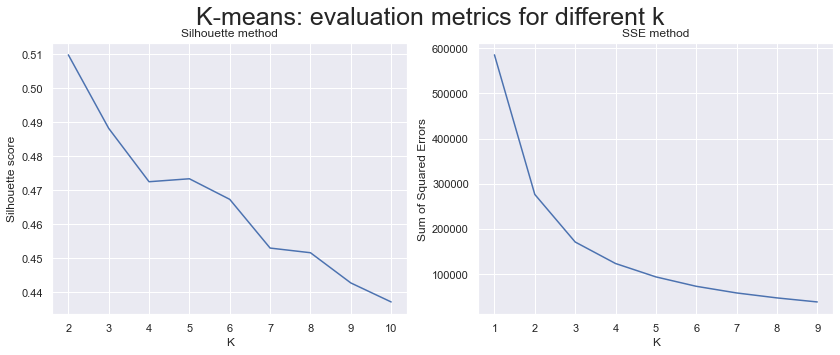

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(14,5))
# Plot silhouettes
plt.subplot(121)
sns.lineplot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silhouette method")
# Plot sse
plt.subplot(122)
sns.lineplot(sse.k, sse.sse)
plt.xlabel("K")
plt.ylabel("Sum of Squared Errors")
plt.title("SSE method")
fig.suptitle("K-means: evaluation metrics for different k",fontsize=25)
plt.show()

The elbow method applied on the SSE graph seems to indicate that 2 and 3  might be relevant choices of ```k``` for this dataset.
Moreover, the silhouette graph also suggests that these values are fair tradeoffs between the goodness of the fit and the number of clusters. By curiosity, we will also keep k=4 as one of the best candidates.

To analyze deeper the values of the silhouettes scores obtained for our candidates we plot the silhouettes score obtained by each data points of each cluster :

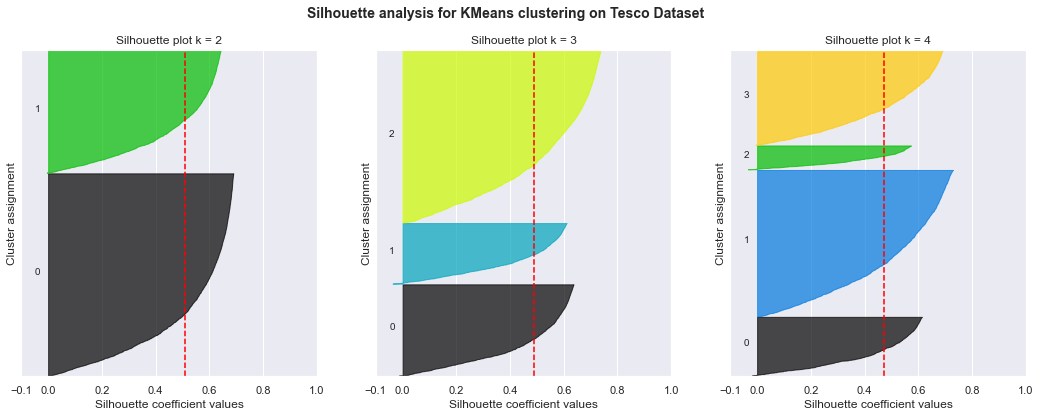

In [12]:
n_clusters_range = [2,3,4]
fig, axs = plt.subplots(1, len(n_clusters_range))
fig.set_size_inches(18, 6)
for j,k in enumerate(n_clusters_range):
    ax = axs[j]
    ax.set_xlim([-0.1, 1])                           # silhouettes lie within [-0.1, 1] here
    ax.set_ylim([0, len(sub_tesco) + (k + 1) * 10])  # inserting blank space between silhouette
    clusterer = KMeans(n_clusters=k, random_state=10)# Do the clustering 
    labels = clusterer.fit_predict(sub_tesco)
    silhouette_avg = silhouette_score(sub_tesco, labels)             # avg silhouette
    sample_silhouette_values = silhouette_samples(sub_tesco, labels) # scores for each sample
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i] # aggregate per cluster
        ith_cluster_silhouette_values.sort()                                  # sort
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)                                # get color from palette
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot k = %d" %k)
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster assignment")
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans clustering on Tesco Dataset "),
                 fontsize=14, fontweight='bold')
plt.show()

Silhouette scores can be interpreted as follows :
 * 1  indicate that the sample is far away from the neighboring clusters
 * 0  indicates that the sample is on or very close to the decision boundary between two neighboring clusters
 * <0 indicate that those samples might have been assigned to the wrong cluster. 

Only for ```k = 4```, we observe higher variability scores (inside clusters) what indicates that the clustering might not be so good. However, for all k, we do not have the presence of clusters with below-average (red dotted line) silhouette scores which is a good point.

### K-means 2D visualisation

#### Dimensionality Reduction : PCA and TNSE
In the previous point, we tried to formally understand the goodness of fit for the clusters found. Here, we will take a more visual approach. To do so we naively project the data on a 2D space using PCA and T-SNE algorithms. We plot the results and label them with the labels produced by the clustering (choose k=3 among the candidates we listed earlier), hoping that the obtained figure will look like the map of London. We obtained the following figure:

In [13]:
# PCA redution
sub_tesco_pca  = PCA(n_components=2).fit(sub_tesco).transform(sub_tesco)
# TSNE reduction
sub_tesco_tsne = TSNE(n_components=2, random_state=0).fit_transform(sub_tesco)

/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lucas_gruaz/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


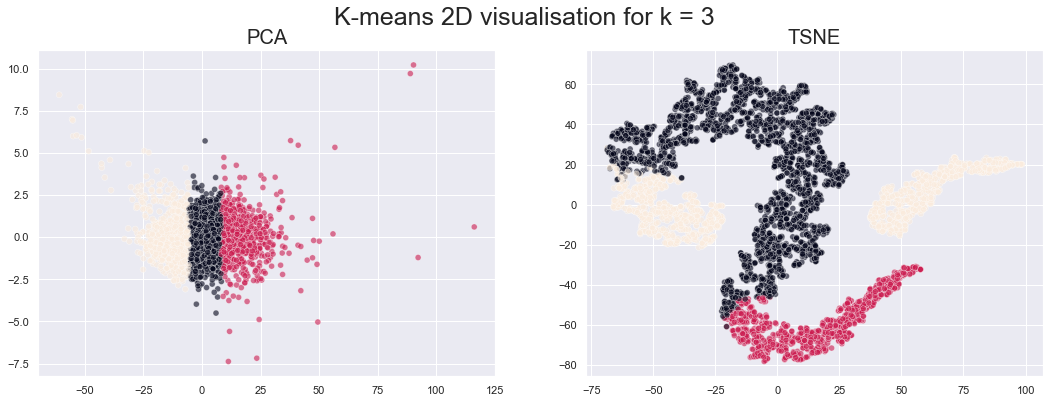

In [14]:
k = 3 # let's choose k arbitrarely from the good ones 
fig, axs = plt.subplots(2, 1, figsize=(18,6))
labels = KMeans(n_clusters=k, random_state=42).fit_predict(sub_tesco)
plt.subplot(121)
ax = sns.scatterplot(sub_tesco_pca[:,0], sub_tesco_pca[:,1], c=labels, alpha=0.6)
ax.set_title("PCA",fontsize=20)
plt.subplot(122)
ax = sns.scatterplot(sub_tesco_tsne[:,0], sub_tesco_tsne[:,1], c=labels, alpha=0.6)
ax.set_title("TSNE",fontsize=20)
fig.suptitle("K-means 2D visualisation for k = %d" % k,fontsize=25)
plt.show()

Here we understand that k = 2 might be a better choice if we think of TSNE. 

If we go back to our initial question, we tried to understand if there was a relationship between similar typical products and similar areas (geographical areas). At the beginning of this notebook, we thought that we might be able to recognize London from those simple dimensionality reduction 2D plots but this is clearly not the case. This does not mean that the previously mentioned relationship does not exist, it simply we have to think more carefully about how we are going to address the question. Thus we need to proceed with a deeper analysis of the clusterings in the geographic space.
## Geographical Clustering visualization 

In the previous cells, we failed to show the presence of a geographical relationship between products and area. To have a better idea of how the clusters look like in the geographical space we create an interactive visualization of these clusters on the real map of London. Using geopandas we represent each area of the dataset on a proper map and we label them using the possible clusterings. 
### Creation of DataFrame of clusters
As a first step, we create a new dataframe ```tesco_year``` that contains only the data for the complete year. In addition, we will add the clustering assignments for various values of k. We choose k to be in the range [2,8]. We do so because we don't want to restrict ourselves to the previously computed candidates and miss a good geographical clustering.

In [15]:
tesco_year = tesco.query("month == 'yea'")
cluster    = tesco_year.copy(deep=True)
max_k = 8 # maximum number of clusters
for k in range(2,max_k+1):
    new_col_name='cluster_'+str(k)
    cluster[new_col_name]='No data'

In [16]:
for lvl in agg_levels:         # iterate over all the aggregation levels : borough,lsoa,msoa...
    # filtered version of the dataset : we only consider the current aggregation level
    tesco_lvl = cluster[cluster.agg_level == lvl]
    for k in range(2,max_k+1): # iterate over all the chosen values of k
        # compute the clustering labels
        labels = KMeans(n_clusters=k, random_state=42).fit_predict(tesco_lvl[feature_names])
        # save the result
        cluster.loc[tesco_lvl.index,'cluster_'+str(k)] = labels
# Save it to .csv for further use
cluster.to_csv('data/tesco_cluster.csv',index=False)
cluster.head(5)

,area_id,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories,month,agg_level,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,E09000001,8.472985,3.361599,9.278065,5.253333,15.779639,1.619850,165.851751,1.618208,yea,borough,1,0,3,1,5,5,5
1,E09000002,9.209959,3.596834,10.793244,5.193872,19.784988,1.590335,187.174390,1.545272,yea,borough,0,1,1,2,4,1,1
2,E09000003,8.594464,3.407353,9.530548,5.129627,17.025950,1.638639,170.655504,1.581507,yea,borough,1,0,3,3,2,3,3
3,E09000004,9.119180,3.466346,10.941085,5.304496,19.997105,1.657118,187.754791,1.551703,yea,borough,0,1,1,2,4,1,1
4,E09000005,8.962466,3.559913,10.148610,5.132915,18.726476,1.585978,180.510586,1.555736,yea,borough,0,2,2,0,3,2,2


### Interactive Clustering visualisation
Now that all the needed clustering are computed and saved we can set up the visualization. We obtain the following result :

In [17]:
cluster = cluster[['area_id','month','agg_level']+[c for c in cluster.columns if c.startswith("cluster")]]
cluster_dict,_,c_agg_levels,c_feature_names = create_datasource(cluster)

In [18]:
from bokeh.palettes import Dark2,Spectral,Set2,Colorblind
def create_cat_color_mapper(state:dict,nan_color='#d9d9d9'):
    """This function create the categorical color mapper"""
    feature  = get_feature(state,tesco_dict=cluster_dict) # Select feature
    n_colors = max(feature.nunique(),3) if feature is not None else 1
    palette  = Set2[max(n_colors,3)][:n_colors][::-1]
    color_mapper=CategoricalColorMapper(palette=palette, factors=[str(k) for k in range(n_colors)])
    return color_mapper

def update_cat_plot(state_field:str, new_val:str,state:dict,plot,geosource):
    """
    Handles interactivity in the visualization
    @param state_field : (str) element of the state that needs to be updated
    @param new_val     : (str) new value of state_field element 
    """
    state[state_field] = new_val  # state update
    # update title
    plot.title.text = "K-Means clustering (k = {0}) for {1}".format(state['feature'][-1],state['agg_level'])
    if state_field == 'feature':                    # update color mapper
        color_mapper = create_cat_color_mapper(state)   # create new mapper
        plot.patches('xs','ys',                     # update patches
            source = geosource,
            fill_color = {'field' :state['feature'], 'transform' : color_mapper},
            line_color = 'black', line_width = 0.25, 
            fill_alpha = 1,
                     #legend_label=state['feature']
                    )
    new_data = json_data(**state,data=cluster_dict) # get the new data and convert to JSON
    geosource.geojson = new_data                    # set new data to trigger recoloring event
    # new hover for the new feature 
    hover = HoverTool(tooltips = [('Area name','@name'),(state['feature'], '@'+state['feature'])])
    # add hover tools to plot
    plot.tools = [hover]

In [19]:
# output notebook to allow inline jupyter interaction
output_notebook()

def cluster_bkapp(doc):
    # default state when the component is loaded for the first time
    state = {'month':'yea','agg_level':'borough','feature':'cluster_2'}
    geosource = GeoJSONDataSource(geojson = json_data(**state,data=cluster_dict))
    # Hover that will show the current feature value for the hovered area + its name
    hover = HoverTool(tooltips = [ ('Area name','@name'),(state['feature'], '@'+state['feature'])])
    # Create figure for the plot
    plot = figure(title = "K-Means clustering (k = {0}) for {1}".format(state['feature'][-1],state['agg_level']), 
            plot_height = 800 , plot_width = 950, toolbar_location = None,
            tools = [hover])
    # Remover axis for nicer layout
    plot.xgrid.grid_line_color = None
    plot.ygrid.grid_line_color = None
    plot.axis.visible = False
    # link data and plot 
    color_mapper   = create_cat_color_mapper(state) # create new mapper
    plot.patches('xs','ys', source = geosource,     # link geosource
        fill_color = {'field' :state['feature'],    # color related to selected feature
                      'transform':color_mapper},    # use the defined colormapper
        line_color = 'black',                       # style : black borders
        line_width = 0.25, fill_alpha = 1,)         # more styling
    #create graphical components for the user to interact
    btn_agg_level  = RadioButtonGroup(labels=c_agg_levels, active=0)    # selection aggregation level
    select_feature = Select(title="Typical product feature:", 
                            value=c_feature_names[0], options=c_feature_names)
    #add event handler
    local_update_plot = lambda st,v: update_cat_plot(st, v,state,plot,geosource)
    btn_agg_level.on_click(           lambda new         : local_update_plot('agg_level',c_agg_levels[new]))
    select_feature.on_change('value', lambda attr,old,new: local_update_plot('feature'  ,new))
    #add components to root document
    doc.add_root(column(btn_agg_level, plot,select_feature))

Loading BokehJS ...

In [20]:
show(cluster_bkapp)

Surprisingly, for many values of ```k```, we can actually make some geographical sense out of the clustering! Let's analyse further some of the plots:

* For ```k = 2```, across all aggreation levels, we can generaly observe that the center and top east part of London tend to be clustered together. If we take a look at the ```lsoa``` plot (the most precise aggregation level), we clearly see two __concentric__ circle-shaped clusters. A further analysis could try to relate these clusters to actual classes of people (for instance densily populated / wealthy areas, who knows?).

* For largers ```k```, this concentric cluster shapes tendency keeps appearing, which is really interesting given the fact that the K-Means algorithm didn't take any geographical metric into account.
* We can almost always distinguish a central cluster.

In the end, we see that the clustering looks quite decent and conforts us in the idea that we are able to give geographical meaning to them. Overall, these results are exciting but it would be interesting to formally quantify them.

## Formal Geographical Validation
In this section, we want to have a piece of more formal evidence that some of our clusterings are good (what we saw on the visualization). Thus we have to find metrics that could reflect the goodness of the clustering in the geographic space. 

### Geographical Silhouette
As a first step we will try to use the silhouette score again but in the geographical domain. To do so we will compute the silhouette score as we did at the beginning of the study but this time we will use the geographical distance as the distance between data points. In order to be able to compare the future results, we will also compute the silhouette score produced by a random clustering. We do so hoping that our clustering will perform significantly better than the random one. 

In [21]:
# To obtain the coordinates of a given area we use the coordinate of the centroid of its geometry. 
geo_coords  = gdf_lsoa.geometry.centroid.apply(lambda p: pd.Series({'x':p.x,'y':p.y}))
geo_coords['area_id'] = gdf_lsoa.area_id
# we link each coordinate with the corresponding area 
geo_coords  = geo_coords.merge(tesco_year,on='area_id',how='inner')[['x','y']]
# to save the results
silhouettes = []
# Try multiple k
for k in range(2, 20):
    # compute the labels for the clustring in the typical products space
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(sub_tesco)
    # Get the Silhouette score using the geographical coordinates of the data instead of the original datapoints  
    geo_score  = silhouette_score(geo_coords, labels)
    # save the result
    silhouettes.append({"k": k, "geo_score": geo_score, "Clustering Type":"k-means"})
    # compute the silhouette score of a random clustering 
    rnd_score = silhouette_score(geo_coords, np.random.randint(k, size=len(labels)))
    # save the random restult 
    silhouettes.append({"k": k, "geo_score": rnd_score, "Clustering Type":"random"})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)
silhouettes.head(4)

,k,geo_score,Clustering Type
0,2,0.102800,k-means
1,2,-0.000217,random
2,3,-0.028515,k-means
3,3,-0.007476,random


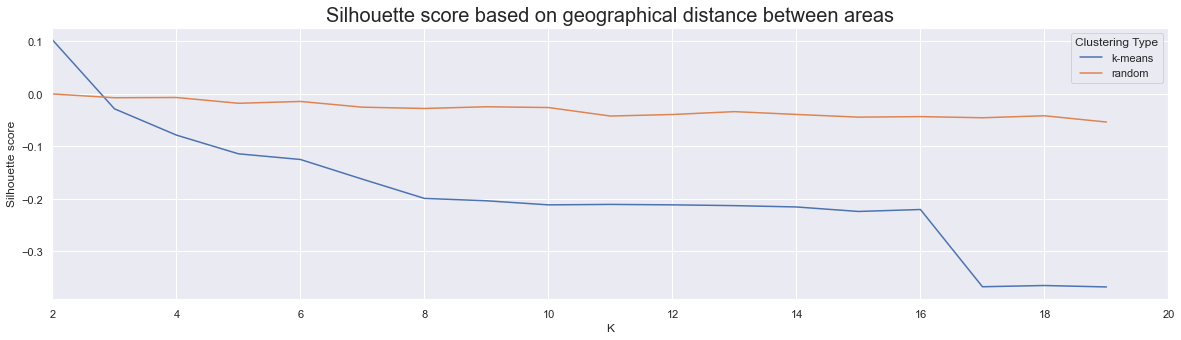

In [22]:
plt.figure(figsize=(20,5))
# Plot the data
ax = sns.lineplot(data=silhouettes, x='k', y='geo_score', hue="Clustering Type")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
ax.set_xlim((2,20))
plt.title("Silhouette score based on geographical distance between areas",fontsize=20)
plt.show()

We see that unfortunately, this does not go in the direction of a good evidence of fit. The scores are quite small compared to the ones we got in the naive analysis. They even goes to negative values, meaning that, on average, points tend to be closer to other clusters than to their centroid, or at least the geographical sense. 

However, we need to take a step back and try to fully undertand why such result have arisen. Indeed, we should remind ourselves that the silhouette score computation relies on the average distance to other points in the same cluster, to which we substract the smallest mean distance to other points in other clusters. This metric is thus likely to produce high scores for dense clusters distributed as a gaussian centered in the centroid. This is is not the shape that we observed in our visualization : we rather saw concentric circles, scattered around the map (they do not form unique blocks)! Indeed, if we were to run a K-means algorithm in the 2D geographical vector space, we would never get such concentric shaped clusters. 

If the sihouette metric is good when we want to evaluate clusters as described in the previous paragraphs, we understood that we should probably try another approach to evaluate our clusters.

### Graph analysis

In this section, we will use a slightly different approach than the previous one. We again use the silhouette score but we will compute it using the following distance metric: the distance between two areas will be defined as the shortest path (smallest number of areas to cross) to go from one area to another. We do so because the centroids of similar areas might be far from each other even if the areas are located next to each other. We hope that by giving a slightly more geographical meaning to the distance measure, we will be able to better evaluate the clusters.

This task would clearly be better solved using a graph approach. We will therefore define a graph G = (V,E) where:

* V : the set of vertices is the set of areas in London.
* E : the set of edges is such that we connect to areas if they have a common border.

Then using this graph, we will compute all the shortest paths possible and use them as the distance metric for the silhouette score. In python, the ```networkx``` package is naturally suited for this task.

Note that we perform this analysis only on the lsoa aggregation level. 

####  Creation of the graph

In [23]:
import networkx as nx
from tqdm import tqdm # to display a progress bar on for loops

In [24]:
def add_neighbors_list(gdf):
    """
    Compute the list of neighboring areas for every area in the given dataframe, and store it in the dataframe
    gdf : Geopandas dataframe that contains every areas and their geometrical information in a column named 'geometry'
    return : augmented dataframe
    """
    l = []
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf.index)):
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)][['area_id']]\
            .query("area_id != '"+str(row.area_id)+"'").area_id.values
        l.append(neighbors)
    gdf["border_neighbors"] = l
    return gdf

In [25]:
# link all areas to their neighbors
gdf_lsoa_neighbors = add_neighbors_list(gdf_lsoa.merge(sub_tesco, how='inner', on='area_id'))
# discard useless information
gdf_lsoa_edges = gdf_lsoa_neighbors[['area_id', 'border_neighbors']]
# takes some time ...
gdf_lsoa_edges.head()

100%|██████████| 4833/4833 [01:36<00:00, 50.07it/s]


,area_id,border_neighbors
0,E01000001,"[E01000002, E01000003, E01032739, E01032740, E..."
1,E01000002,"[E01000001, E01000003, E01002704, E01032739]"
2,E01000003,"[E01000001, E01000002, E01002704, E01002706, E..."
3,E01000005,"[E01004293, E01004294, E01004310, E01032739, E..."
4,E01000006,"[E01000009, E01000044, E01000068, E01000071]"


In [26]:
# Flatten the lists to put the dataframe in a networkx-friendly form
edges = pd.DataFrame([[gdf_lsoa_edges.area_id[i], x] 
               for i, y in gdf_lsoa_edges['border_neighbors'].iteritems() 
                    for x in y], columns=['area_id', 'neighbor'])
edges.head()

,area_id,neighbor
0,E01000001,E01000002
1,E01000001,E01000003
2,E01000001,E01032739
3,E01000001,E01032740
4,E01000001,E01033490


In [27]:
# Create graph from edge list, using columns area_id and neighbor
G = nx.from_pandas_edgelist(edges, 'area_id', 'neighbor')

#### Creation of the distance matrix
We now create a distance matrix such that it's $(i,j)$ entry contains the length of the shortest path between area $i$ and area $j$. This matrix is thus symmetric.

In [28]:
# Compute shortest path length for every pair of nodes in the graph
shortest_path_len = dict(nx.shortest_path_length(G))

# Put it in a matrix
distance_matrix = pd.DataFrame(shortest_path_len)

# Sort the rows and columns so that they are in the same order (i.e there are zeros in the diagonal)
distance_matrix = distance_matrix[sub_tesco.index].sort_index()
distance_matrix.head()

,E01000001,E01000002,E01000003,E01000005,E01000006,E01000007,E01000008,E01000009,E01000010,E01000011,...,E01033737,E01033738,E01033739,E01033740,E01033741,E01033742,E01033743,E01033744,E01033745,E01033746
E01000001,0,1,1,2,22,21,20,21,20,22,...,25,20,29,28,29,27,29,27,30,17
E01000002,1,0,1,2,22,21,20,21,20,22,...,25,20,29,28,29,27,29,27,30,17
E01000003,1,1,0,3,23,22,21,22,21,22,...,26,21,30,29,30,28,30,28,31,18
E01000005,2,2,3,0,21,20,19,20,19,21,...,25,20,29,28,29,27,29,27,30,17
E01000006,22,22,23,21,0,2,3,1,2,2,...,45,40,49,48,49,47,49,47,50,37


#### Silhouette scores computation
We again compute silhouette score as above for different values of k, and compare it to a random clustering.

In [29]:
silhouettes = []
# Try multiple k
for k in range(2, 20):
    # compute the labels for the clustring in the typical products space
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(sub_tesco)
    # Get the Silhouette score using the geographical coordinates of the data instead of the original datapoints  
    graph_score  = silhouette_score(X=distance_matrix.astype(float), labels=labels, metric="precomputed")
    # save the result
    silhouettes.append({"k": k, "graph_score": graph_score, "Clustering Type":"k-means"})
    # compute the silhouette score of a random clustering 
    rnd_score = silhouette_score(X=distance_matrix.astype(float), labels=np.random.randint(k, size=len(labels)), metric="precomputed")
    # save the random restult 
    silhouettes.append({"k": k, "graph_score": rnd_score, "Clustering Type":"random"})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

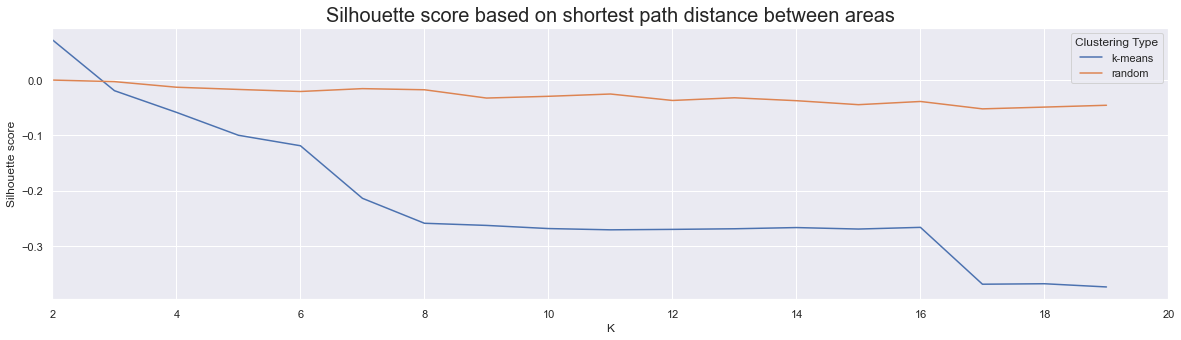

In [30]:
plt.figure(figsize=(20,5))
# Plot the data
ax = sns.lineplot(data=silhouettes, x='k', y='graph_score', hue="Clustering Type")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
ax.set_xlim((2,20))
plt.title("Silhouette score based on shortest path distance between areas",fontsize=20)
plt.show()

#### Results

The obtained results are very similar to the previous analysis. We might have put to much hope on the changes made by the distance metric. This might be due to the fact that the silhouette score is not well suited for our application. Thus we need to define a more appropriate metric to evaluate the graph. Note that despite the fact that the silhouette score is bad we are still convinced that the clustering is meaningful in the geographic space (because of the visualization).

### Border Scores
In this section, we create a new metric to evaluate if geographically close areas tend to belong to the same cluster of type. We proceed as following: for each area of the dataset we look at all its direct geographic neighbors and compute the number of neighbors belonging to the same cluster as the original area. We illustrated this in the following figure : 
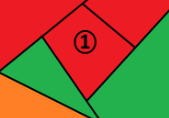
> Here the score computed for area 1 is two, area 1 belongs to the red cluster and has two red neighbors. 

Once we have computed this score for every area of the dataset we group the result per cluster by averaging the previously computed scores. The obtained result is the following: for a given cluster (between 0 and k)  we know the expected number of neighbors belonging to the same given cluster. Since this metric depends on the average number of neighbors in the graph we cannot simply say that the obtained number is high or low. To have a comparison basis we repeated the procedures described above but using random assignments for the labels. 

This new metric is defined more locally. A cluster can be split into two parts located at opposite sides of London and still obtain a good score (what we want) while still being fairly general (we do not want to design a metric that will always return a good score for what we are trying to show).

#### Data preparation

In this section, we will simply preprocess our dataframe so that it contains the number of border neighbors for each area as an extra column:

1. The first step will be to add k-means and random clusters assignments to our original geopandas lsoa dataframe
2. Next, we will compute the set of neighbors for each area and from it we will compute the number of those neighbors that have the same cluster as the considered area.

> The added columns are : ```cluster_border_neighbors_k``` and ```cluster_border_neighbors_random_k``` for all considered ```k```.


In [31]:
def add_clusters(gdf):
    '''Add the cluster assignments to the gdf + random clusters assignments'''
    df = cluster.query("agg_level == 'lsoa'")
    # all cluster columns
    cols = [c for c in df.columns if c.startswith("cluster")]
    # select the right subset of data and filter out nans
    out  = gdf.merge(df[['area_id']+cols],on='area_id',how='inner').query("cluster_2 != 'No data'")
    out[cols] = out[cols].astype('int')
    out = out.reset_index()
    # add random clustering assignments
    for k in range(2,max_k +1):
        out['cluster_random_'+str(k)] = np.random.randint(k, size=len(out))
    return out

In [32]:
gdf = add_clusters(gdf_lsoa)
gdf.head(2)

,index,area_id,name,geometry,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_random_2,cluster_random_3,cluster_random_4,cluster_random_5,cluster_random_6,cluster_random_7,cluster_random_8
0,0,E01000001,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18...",0,2,2,2,5,2,2,1,1,0,2,5,4,6
1,1,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18...",0,2,2,2,5,2,2,1,2,1,1,1,6,2


In [33]:
def add_neighbors_clusters(gdf):
    '''For each area of the given dataset: link it with the number of neighbors having the same cluster label'''
    cols = [c for c in gdf.columns if c.startswith("cluster")]
    l = [None] *len(gdf) # empty list
    # iterate over all areas
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf.index)):
        # set of neighbords
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)][['area_id']+cols]\
            .query("area_id != '"+str(row.area_id)+"'")[cols]
        # number of neighbors with same cluster assignment
        l[idx] = np.sum(neighbors == row[cols])
    # create data frame out of this computation
    tmp = pd.concat(l,axis=1).T.rename(
        columns={c:'cluster_border_neighbors_'+("random_" if c.find('random')!=-1 else "")+c[-1] 
                 for c in cols})
    return pd.concat((gdf,tmp),axis=1)

In [34]:
# takes some time ...
neighbors = add_neighbors_clusters(gdf)

100%|██████████| 4833/4833 [01:54<00:00, 42.21it/s]


#### Border Scores computation

Now that, we have a functional dataframe, we can use a ```groupby``` operation to compute for each cluster, the mean border scores. 
Additionaly, we will compute the same scores for the random clusters assignments. 

Since for a given ```k```, on average we should have the same number on points in each cluster for a random clustering, we will aggregate one more time the result (using a second ```mean```) to get an even more realiable estimate of the real random border score. We can do that since we do not care about the differences induced by the clusters in a randomized set-up (in theory they should be none).

In [35]:
def create_border_scores(gdf):
    '''Return the border scores given the neighborh clusters'''
    l = []
    for k in range(2,max_k+1):
        # mean border scores
        col       = "cluster_"+str(k)
        score_col = "cluster_border_neighbors_" + str(k)
        sdf = gdf.groupby(col)[score_col].mean()\
            .drop(columns=['index'])\
            .rename('mean_border_score_'+str(k))
        # random assignment
        random_col       = 'cluster_random_'+str(k)
        random_score_col = "cluster_border_neighbors_random_" + str(k)
        random_mean      = gdf.groupby(random_col)[random_score_col]\
                                .mean()\
                                .mean()
        #create output pd series
        l.append(sdf.append(pd.Series({'random':random_mean})))
    out = pd.concat(l,axis=1)
    out = out.rename(columns={c:"cluster_"+str(int(c)+2) for c in out.columns})
    out.index = out.index.astype(str)
    return out.sort_index()

In [36]:
mean_borders = create_border_scores(neighbors)
mean_borders.to_csv('data/mean_border_score.csv',index=False)
mean_borders

,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,4.283726,3.545064,3.275125,2.734783,2.568956,2.360133,2.444638
1,3.388767,2.537017,2.526681,0.821429,1.398964,2.008264,1.797557
2,NaN,3.139927,2.730583,2.157480,2.683307,1.980769,2.089005
3,NaN,NaN,1.302452,2.278826,0.000000,2.179195,1.815962
4,NaN,NaN,NaN,2.840268,2.043400,0.000000,0.866242
5,NaN,NaN,NaN,NaN,2.129450,2.235294,2.280161
6,NaN,NaN,NaN,NaN,NaN,0.906977,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,2.153846
random,2.723392,1.806565,1.378737,1.062081,0.922586,0.765179,0.675919


####  Results

It would be nice to have a good plot to help us undersand the previous matrix. In the next cells, we are going to produce several ```barplots``` (one for each value of ```k```). We will then be able to compare the performance of our clustering compared to a random one.

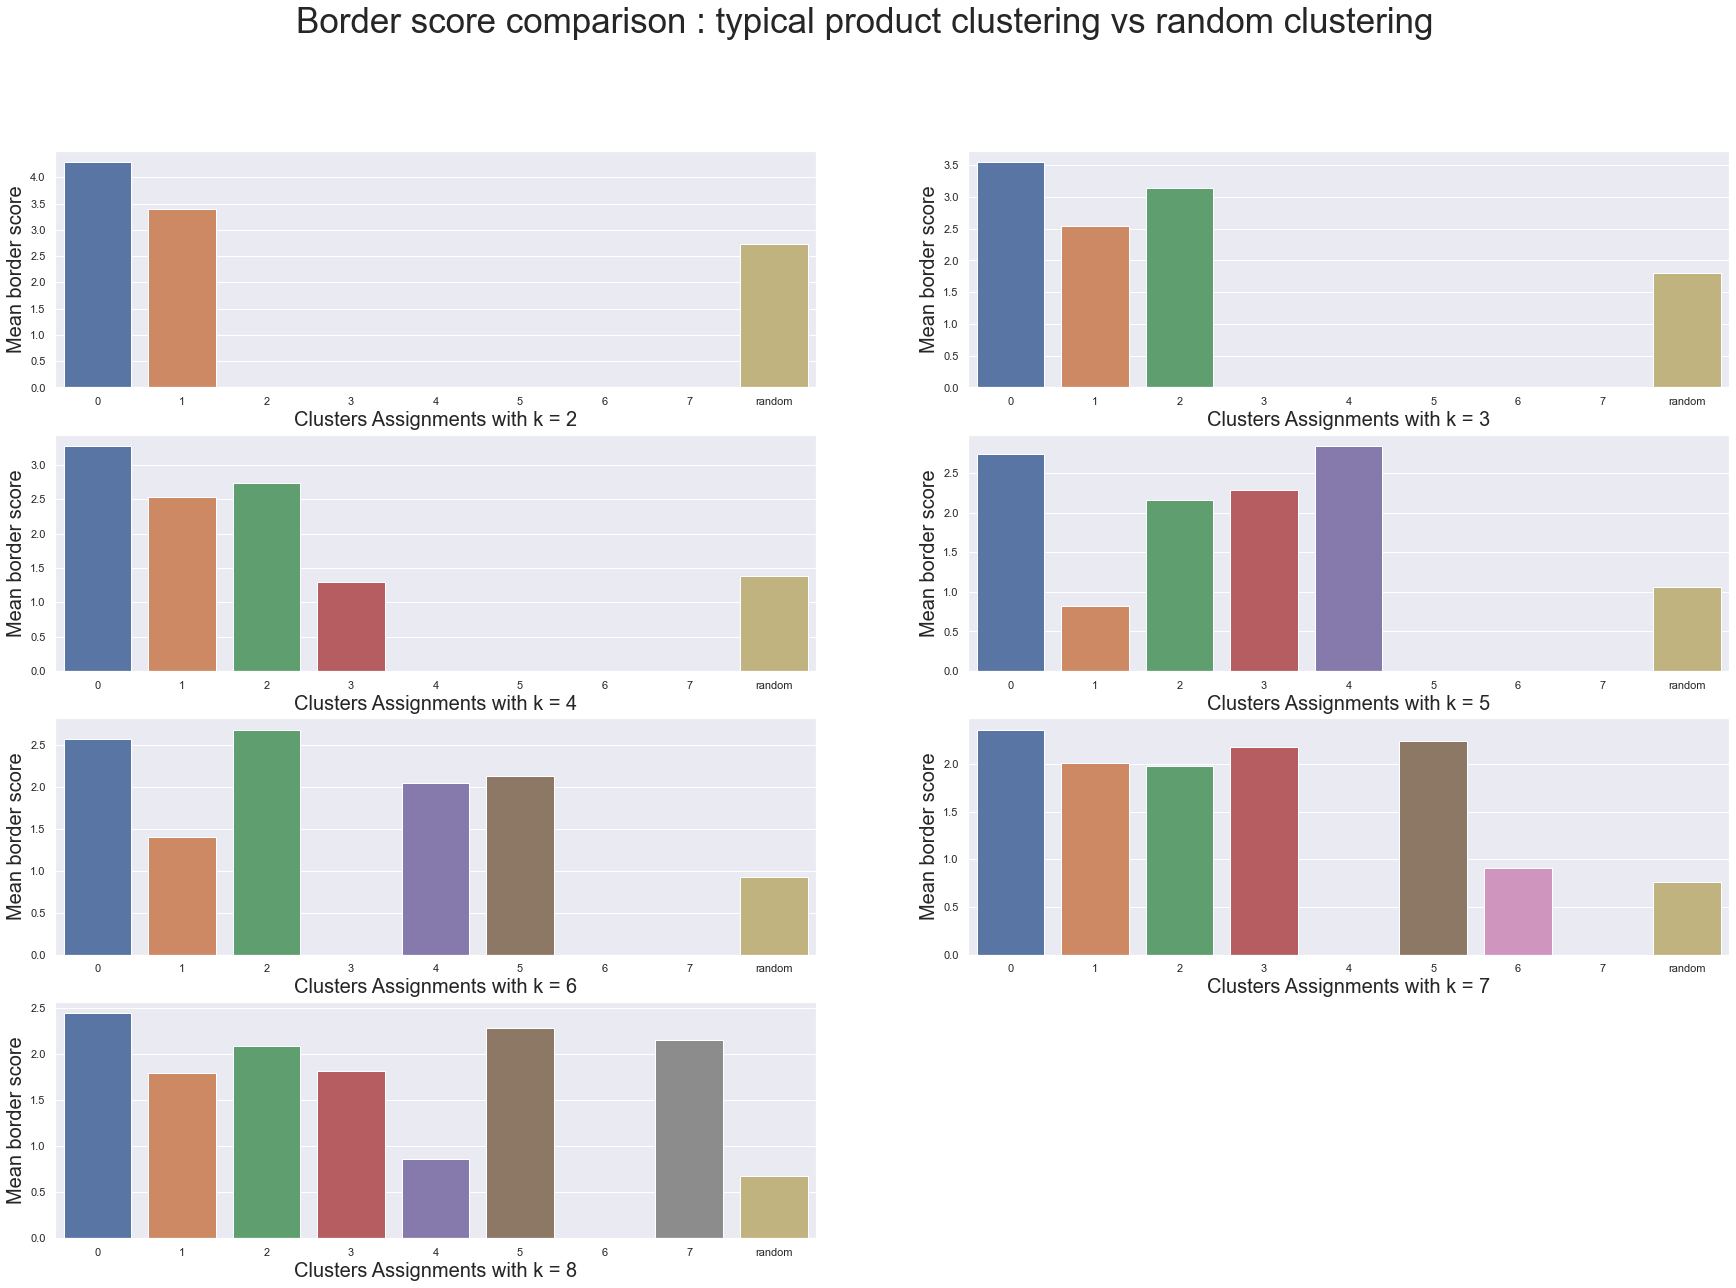

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(30,20))
for i in range(1,8):
    plt.subplot(4,2,i)
    ax = sns.barplot(x = mean_borders.index, y="cluster_"+str(i+1),data=mean_borders)
    ax.set_xlabel("Clusters Assignments with k = "+str(i+1),fontsize=20)
    ax.set_ylabel("Mean border score",
                  fontsize=20)
fig.suptitle("Border score comparison : typical product clustering vs random clustering", fontsize=35)
plt.show()

At first sight, this already looks quite promising but let's dive into the details:

1. For each ```k```, almost all clusters do better than random.
2. When ```k``` increases, the clusters tend to ressemble less and less to the random one, on average.
3. When ```k``` increases, clusters with a score extremely low (close to 0) appear


Using this metric and the visualisation, we are finally able to somehow demonstrate that there is indeed some evidence that the clustering on typical product produces, at the same time geographically similar clusters. 

If this result at least shows that we can come up with some metric to evaluate such a clustering task, it would be better if we got the same result using a different approach, just to assess the validity of our findings. However, due to the time constrains implied by this assignment, we decided not to take further steps in that direction.

# (c) Cluster analysis
In this section we will analyze our clustering through the differences in the average typical product between the clusters. We choose k=4 and the aggregation level of LSOAs in order to have a more precise and complex clustering.

We start by loading the data and put it in a nice form for comparison between clusters.

In [38]:
# Load the data with typical product and clusters for each area
tesco_cluster = pd.read_csv('data/tesco_cluster.csv')

In [39]:
# Nutrients of interest
typical_products = ['fat', 'saturate', 'sugar', 'protein', 'carb', 'fibre',
       'energy_tot', 'h_nutrients_calories']
# K-means with k=4
cluster_name = 'cluster_4'
# Take only the columns and rows of interest
cluster_constitution = tesco_cluster.query('month=="yea"').query('agg_level=="lsoa"')[typical_products+[cluster_name]]

# Min-max scaling in order to be able to reasonably compare between clusters
m,M = cluster_constitution[typical_products].min(),cluster_constitution[typical_products].max()
cluster_constitution[typical_products] = (cluster_constitution[typical_products]-m)/(M-m)


We can now plot the differences in the nutrients between the clusters. We also compute the entropy of these to detect which nutrient class is more determining and important to separate the clusters. The smaller the entropy, the larger the importance of the corresponding nutrient.

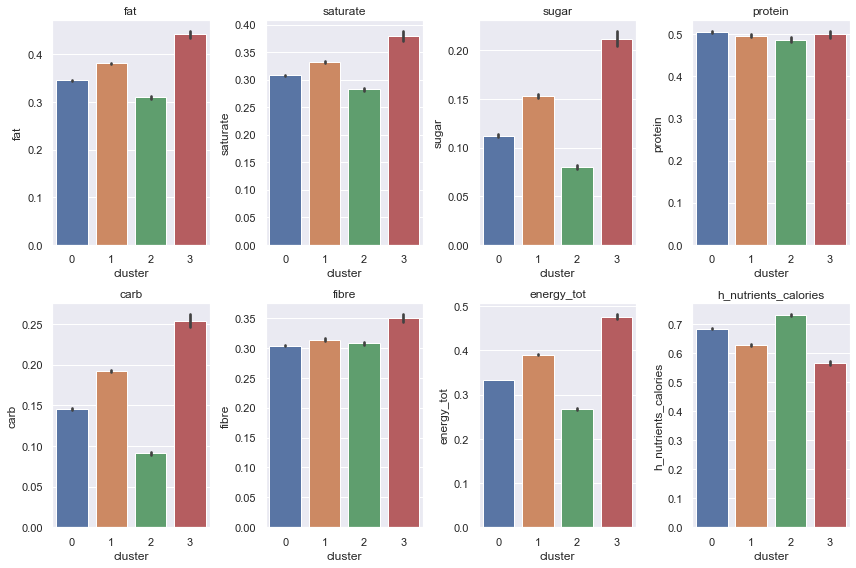

Entropy of carb                 : 1.323
Entropy of sugar                : 1.325
Entropy of energy_tot           : 1.364
Entropy of fat                  : 1.378
Entropy of saturate             : 1.38
Entropy of h_nutrients_calories : 1.382
Entropy of fibre                : 1.385
Entropy of protein              : 1.386


In [40]:
from scipy.stats import entropy

# Store the entropies in a dict
entropies = {}

plt.figure(figsize=(12,8))
for i,t in enumerate(typical_products):
    # 8 subplots
    plt.subplot(241+i)
    plt.title(t)
    # Each bar in the barplot correspong to a different cluster
    sns.barplot(x=cluster_name, y=t, data=cluster_constitution).set_xlabel('cluster')
    
    # Compute the mean by cluster for each nutrient
    mean_per_cluster = cluster_constitution[[t,cluster_name]].groupby(cluster_name).agg(np.mean)
    # Normalize it so that it sums up to 1 for each cluster
    mean_norm = mean_per_cluster/np.sum(mean_per_cluster)
    # Compute the entropy
    entropies[t] = entropy(mean_norm)
    
plt.tight_layout()
plt.show()

# Sort the dictionary in ascending order of entropy
entropies = dict(sorted(entropies.items(), key=lambda item: item[1]))
# Print the entropy for each nutrient
for k,v in entropies.items():
    print("Entropy of " + str(k).ljust(20) + " : "+str(round(v[0],3)))

We see from both the graphs and the entropies that carbohydrates and sugar are the most determining nutrient classes to separate the cluster (we have more information about the cluster of a given area if we know about the amount of carbohydrates its typical product has than any other nutrient class). On the opposite side, the amout of proteins doesn't give much information.

This information can be used to answer one of our first questions : 
> "In the context of an advertising campaign, which areas of the city should be associated with which kind of products?"

For example, a company selling a product that has a high concentration of carbohydrates and sugar can focus their advertising campaign on areas that belong to the 4th cluster. 

## Diabetes prevalence comparison
Let's repeat the experience, but this time using the aggregation level of oswards and we will try to compare it to the data from ```diabetes_estimates_osward_2016.csv``` to see if there's a correlation between a cluster's average typical product and its diabetes prevalence.

In [41]:
# Take only the columns and rows of interest
cluster_osward = tesco_cluster.query('month=="yea"').query('agg_level=="osward"')[typical_products+[cluster_name]+['area_id']]
# Load the diabetes data
diabetes = pd.read_csv(data_path + 'diabetes_estimates_osward_2016.csv', index_col='area_id',
            usecols=['area_id','estimated_diabetes_prevalence'])\
            .rename(columns={'estimated_diabetes_prevalence':'diabetes'})

# Join the two tables
cluster_osward = cluster_osward.join(diabetes, how='inner', on='area_id')
# Normalize the diabetes columns
cluster_osward['diabetes'] /= max(cluster_osward['diabetes'])
cluster_osward

,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories,cluster_4,area_id,diabetes
5849,9.488797,3.693721,10.966213,4.977560,19.381951,1.564721,187.114757,1.532485,2,E05000026,0.642857
5850,9.733634,3.565913,10.514427,5.211694,18.950348,1.581960,188.638145,1.541202,2,E05000027,0.555556
5851,9.216310,3.613582,10.690272,5.192412,19.662048,1.572323,186.861792,1.549774,2,E05000028,0.634921
5852,9.700137,3.961264,12.938606,4.718184,20.084734,1.550344,190.783934,1.514848,2,E05000029,0.626984
5853,9.381808,3.614663,11.332898,5.307003,19.581403,1.607947,188.136201,1.540547,2,E05000030,0.579365
...,...,...,...,...,...,...,...,...,...,...,...
6392,8.625319,3.439466,9.142955,5.223677,15.709293,1.614696,166.114027,1.593240,1,E05009401,0.238095
6393,8.625044,3.416642,8.466422,5.446781,15.066960,1.634360,165.219435,1.625527,1,E05009402,0.317460
6394,8.452109,3.426154,8.980804,5.161370,14.747339,1.535007,161.223709,1.622566,1,E05009403,0.317460
6395,8.671919,3.461223,8.906173,5.520311,16.211390,1.612818,170.143429,1.611194,1,E05009404,0.452381


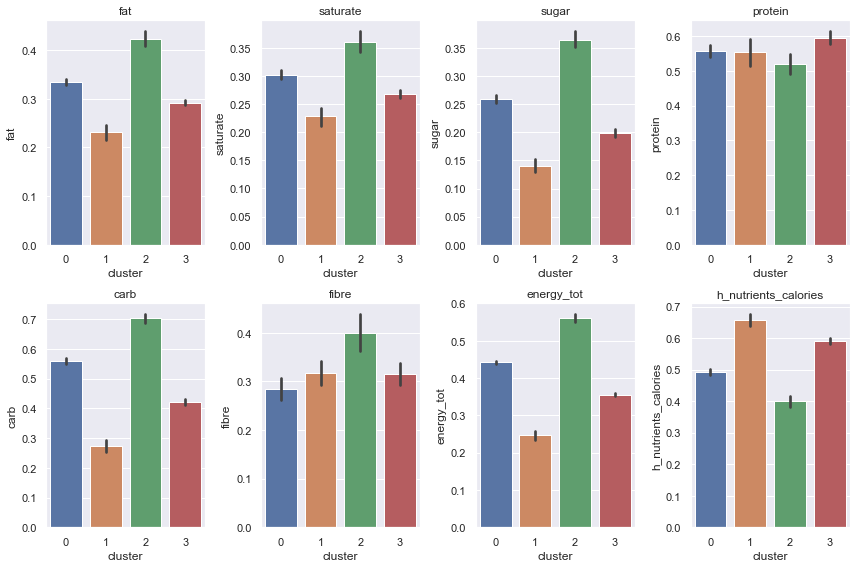

In [42]:
# Min-max scaling the nutrients in order to be able to reasonably compare between clusters
m,M = cluster_osward[typical_products].min(),cluster_osward[typical_products].max()
cluster_osward[typical_products] = (cluster_osward[typical_products]-m)/(M-m)

plt.figure(figsize=(12,8))
for i,t in enumerate(typical_products):
    # 8 subplots
    plt.subplot(241+i)
    plt.title(t)
    # Each bar in the barplot correspong to a different cluster
    sns.barplot(x=cluster_name, y=t, data=cluster_osward).set_xlabel('cluster')
    
    # Compute the mean by cluster for nutrient t
    mean_per_cluster = cluster_osward[[t,cluster_name]].groupby(cluster_name).agg(np.mean)
        
plt.tight_layout()
plt.show()

This time we could expect the cluster 2 to have a higher diabetes prevalence, followed by cluster 0 since their typical product's amount of sugar, fat and total energy is higher than for the two other clusters (this is at least what common sense could let us think). Let's verify this with proper data analysis.

Let's first plot the diabetes prevalence average for each cluster.

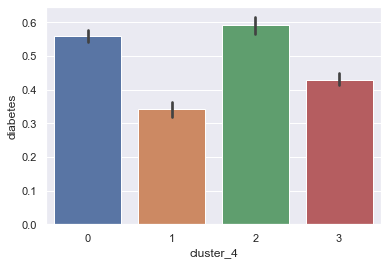

In [43]:
sns.barplot(x=cluster_name, y='diabetes', data=cluster_osward)

It looks pretty clear on the plot that our intuition was good : there is a clear difference between clusters. Even though the errors bars between cluster 0 and cluster 2 seem to overlap, both are significantly higher than the two other clusters.

Let's now try to fit some logistic regression to this data.

In [44]:
import statsmodels.formula.api as smf
# Express te relation between 'diabetes' and the categorical variable 'cluster'
mod = smf.logit(formula='diabetes ~ C('+cluster_name+')', data=cluster_osward)

res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.663703
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               diabetes   No. Observations:                  547
Model:                          Logit   Df Residuals:                      543
Method:                           MLE   Df Model:                            3
Date:                Fri, 11 Dec 2020   Pseudo R-squ.:                 0.04225
Time:                        17:26:44   Log-Likelihood:                -363.05
converged:                       True   LL-Null:                       -379.06
Covariance Type:            nonrobust   LLR p-value:                 5.163e-07
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2387      0.144      1.655      0.098      -0.044       0.521
C(cluste

This is confirmed : there is a significant difference between cluster 0 and cluster 1 and 3 (p-value < 0.05), but not between cluster 0 and cluster 2. The R-squared is not very high though, which means that a lot about diabetes prevalence is not explained by this very simple model (which is natural). But still, we managed to show some important differences between the clusters, which suggests that our clustering is meaningful.

# (d) Practical usage of clustering
## A feature for ML models
In this section, we will do a replication of the obesity regression model definied in ```Tesco``` paper and we will try to improve it by including a new categorical feature : the clustering. We hope to be able increase the amount of variablity explained by the model (```R2```). Obsivously, we will have to quantify the improvement and choose a ```k``` high enough to have a meaningful impact on the model.
### Data loading and scaling
In the following cell, we will simply ready the same data avialable for the replication

1. ```osward  ```: osward tesco data for the entire year 
2. ```diabetes```: diabete prevalence data for all area_ids

In [45]:
osward   = pd.read_csv(data_path + 'year_osward_grocery.csv' , index_col='area_id', 
            usecols=['area_id','energy_carb','h_nutrients_calories','avg_age',
                     'female','num_transactions','people_per_sq_km'])\
            .rename(columns={'h_nutrients_calories':'entropy',
                    'num_transactions':'transactions',
                    'people_per_sq_km':'density'})
diabetes = pd.read_csv(data_path + 'diabetes_estimates_osward_2016.csv', index_col='area_id',
            usecols=['area_id','estimated_diabetes_prevalence'])\
            .rename(columns={'estimated_diabetes_prevalence':'diabetes'})

As writen in the paper, we use a ```MinMaxScaler``` to normalise the data.

In [46]:
from  sklearn.preprocessing import MinMaxScaler
# join the data to have all the information in the same df
diabetes_regression =  osward.join(diabetes,how='inner')
# scale features
min_max_scaler      = MinMaxScaler()
diabetes_regression.iloc[:,:] = min_max_scaler.fit_transform(diabetes_regression)
osward.iloc[:,:]              = min_max_scaler.fit_transform(osward)

We will study the impact of the following values of ```k```

> 2,3,...,9

Therefore, we will compute the clustering assigments as done many times before and store them in the ```cluster``` variable. 

In [47]:
cluster = pd.DataFrame(index=osward.index)
k_range = range(2, 15)
for k in k_range:
    # Assign the labels to the clusters
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(osward)
    cluster['cluster_'+str(k)] = labels

diabetes_regression = diabetes_regression.join(cluster, how='inner')

### Replication : Table 2 (OLS on the number of diabetes prevalence) 
We are ready to perform the actual regression task. Will first try to replicate the model summarised in table 2 of the Tesco paper in order to have a comparison basis

In [48]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.ols(formula='diabetes ~ energy_carb + entropy + avg_age + female + transactions + density', 
              data=diabetes_regression)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               diabetes   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     145.1
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          3.45e-109
Time:                        17:26:46   Log-Likelihood:                 412.45
No. Observations:                 547   AIC:                            -810.9
Df Residuals:                     540   BIC:                            -780.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9357      0.081     11.517   

If we compare our result to table 2 in the paper, we find that our model is almost equal to the one used in the paper (```coef``` are all equal up to the 3rd decimal, standard errors are all equal and the ```R2``` matches). We have thus managed to create a similar set up as in the paper. Since we know that the variable used are relevant for this prediction task, we can refer to this model when we will study the impact including the clustering assignments as extra features to the model. 

The import metric to remember is the ```Adj R2 = 0.613```, we will use this to compare with the models definied in the following cells.

### Cluster Features 

To evaluate the preditive power of te clustering assignments, we will simply run the following experiment :

> For each value of ```k```, we fit a OLS using the same independent variables as in the paper but we will also add the categorical variable ```cluster_k```.

We record the the following output metrics:

1. ```Adj R2```: standard metric of a regression task
2. ````mean significant clusters````: the number of clusters having a p-value smaller than ```5%```, meaning that we can reject the hypothesis that the fitted correspondant clusters actually have a 0 value (and therefore have some predictive power). We simply take the ```mean``` to be able to compare this between between various values of ```k```

We also print the summary of the model, if the reader is interested.

In [49]:
cluster_regression_metrics = pd.DataFrame(
    index=list(k_range), 
    columns=['adj_R2','significant_clusters'],
    dtype=np.float64)
for k in k_range:
    mod = smf.ols(
        formula='diabetes ~ energy_carb + entropy + avg_age + female + transactions + density + C(cluster_{k})'\
            .format(k=k), 
        data=diabetes_regression)
    res = mod.fit()
    print(res.summary())
    cluster_regression_metrics.loc[k,'adj_R2'] = res.rsquared_adj
    cluster_regression_metrics.loc[k,'significant_clusters'] = np.mean(res.pvalues.iloc[1:k] < 0.05)

                            OLS Regression Results                            
Dep. Variable:               diabetes   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     128.3
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          1.84e-110
Time:                        17:26:46   Log-Likelihood:                 418.03
No. Observations:                 547   AIC:                            -820.1
Df Residuals:                     539   BIC:                            -785.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8842      0.08

                            OLS Regression Results                            
Dep. Variable:               diabetes   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     93.79
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          5.73e-123
Time:                        17:26:46   Log-Likelihood:                 459.91
No. Observations:                 547   AIC:                            -893.8
Df Residuals:                     534   BIC:                            -837.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6725      0.08

                            OLS Regression Results                            
Dep. Variable:               diabetes   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     58.22
Date:                Fri, 11 Dec 2020   Prob (F-statistic):          4.93e-116
Time:                        17:26:47   Log-Likelihood:                 459.16
No. Observations:                 547   AIC:                            -878.3
Df Residuals:                     527   BIC:                            -792.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.7694    

In [50]:
cluster_regression_metrics

,adj_R2,significant_clusters
2,0.620100,1.000000
3,0.628838,1.000000
4,0.643913,0.333333
5,0.648310,0.500000
6,0.644331,0.400000
7,0.670985,0.333333
8,0.685358,0.714286
9,0.674614,0.000000
10,0.665279,0.333333
11,0.676338,0.300000


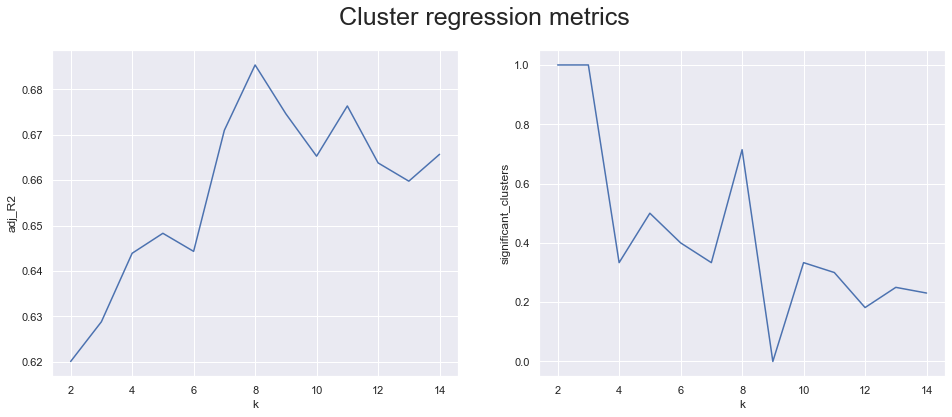

In [51]:
cluster_regression_metrics['k'] = cluster_regression_metrics.index
fig, ax = plt.subplots(1,2, figsize=(16,6))
plt.subplot(1,2,1)
sns.lineplot(x="k", y="adj_R2",data=cluster_regression_metrics)
plt.subplot(1,2,2)
sns.lineplot(x="k", y="significant_clusters",data=cluster_regression_metrics)
fig.suptitle("Cluster regression metrics", fontsize=25)
plt.show()

The results look interesting, we observe an increase in ```Adj R2``` when ```k``` grows, reaching a peak at ```k = 8```. The maximum value ```Adj_R2* = 0.685``` constitutes a significant improvement compared to the value of the base model (```Adj_R2* = 0.613```). With the fact that ```71%``` of the clusters are statisfically signicant, we can conclude that the added clusters have indeed some non negligeable predictive power. This could be explained by the fact that, as seen previously, the clustering assignments in themselves encode some geographical value which could have been exploited by the OLS model.

The previous plots also tells us that a certain number of clusters (not to low value of ```k```) is required in order to observe a good increase in ```Adj R2```. Using the fact that the proportion of signicant cluster is somehow high for values of ```k < 8 (optimum here)```, a possible explanation might be that the preditive power hidden in the clusters is there but the too small number of clusters does not allow the OLS algorithm to fully decode all the geographical information. Augmenting the granularity appears to solve this problem, until we reach a peak, after which the clusters start to lose predictive power (more noise and less predicable when ```k``` grows).

#  (e) Conclusion
Through this project we created some tools, such as an interactive map, to visualize London's areas and their corresponding typical product as given in the Tesco dataset. To get deeper into this analysis, we decided to use some unsupervised machine leaning techniques such a K-means clustering. We saw that clustering can be used to visualize the high dimensional typical product in 2D. We then displayed the resulting clusters on the map, which helped us to highlight some link between typical product of the different areas and their geographical location. To formally verify this link, we tried different approaches and, after some inconclusive attempts, we finally managed to formally support our claims.

We then analyzed our clustering a bit deeper. We assessed the difference between the clusters in term of the average typical product of each cluster. We showed some huge difference and explained how this could be used in finding the optimal target region in the context of an advertising campaign for example (which answered one of our first questions). We also cross-referenced this clustering data with London's data about diabetes prevalence to try to assess some underlying link. This was successful and some significant differences in the diabetes prevalence was highlighted between the clusters.

We believe that the notebook answers all of the initial questions, by the (interactive) visualizations and the formal analysis. There are other areas in which such an analysis can be useful, such as :
* Adapt product offer/prices for grocery shops
* Supply chain management improvements : optimize truck journey
* Insurance : adapt prices according level of risk induced by food on health according to geographical areas
* Marketing / Advertisement
* Trash : create new installations/facilities to better fit the demand at geographical level: add more plastic trashes in clusters with high consumption of sugar for instance

There are many fields of application of such a study. In the end, we can easily imagine how we could extend our work further. All of our study raises more question related on food : can we relate wealthier area in terms of the clustering found, etc.